# Téléchargement d'ensembles de données depuis PyTorch

Pour charger un ensemble de données à partir de PyTorch, utilisez le code suivant. Outre le téléchargement de l'ensemble de données, le code suivant montre comment utiliser les chargeurs de données pour économiser des ressources en chargeant les images par lots, plutôt que toutes à la fois :

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

La variable de transformation est utilisée pour définir l'ensemble des transformations à effectuer sur l'ensemble de données. Dans ce cas, le jeu de données sera à la fois converti en tenseurs et normalisé dans toutes ses dimensions.

In [ ]:
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dans le code précédent, le jeu de données à télécharger est MNIST. Il s'agit d'un ensemble de données populaire qui contient des images de nombres en niveaux de gris écrits à la main de zéro à neuf. Les ensembles de données PyTorch fournissent à la fois des ensembles d'entraînement et de test.

Comme on peut le voir dans l'extrait précédent, pour télécharger le jeu de données, il est nécessaire de dénir la racine des données, qui, par défaut, doit être dénie comme data. Ensuite, dénissez si vous téléchargez l'ensemble de données d'entraînement ou de test. Nous définissons l'argument de téléchargement sur True. Enfin, nous utilisons la variable de transformation que nous avons dénie précédemment pour effectuer les transformations sur les jeux de données :

In [ ]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shue(idx)
split_size = int(np.oor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

Étant donné que nous avons besoin d'un troisième ensemble de données (l'ensemble de validation), l'extrait de code précédent est utilisé pour partitionner l'ensemble d'apprentissage en deux ensembles. Tout d'abord, la taille de l'ensemble de validation est définie, puis la liste des index qui seront utilisés pour chacun des ensembles de données est définie (les ensembles d'apprentissage et de validation)

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

Dans l'extrait précédent, la fonction SubsetRandomSampler() de PyTorch est utilisée pour diviser l'ensemble d'apprentissage d'origine en ensembles d'apprentissage et de validation en échantillonnant de manière aléatoire les index. Cela sera utilisé dans l'étape suivante pour générer les lots qui seront introduits dans le modèle à chaque itération :

In [ ]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler)

dev_loader = torch.utils.data.DataLoader(train_data,
                                         batch_size=batch_size,
                                         sampler=dev_sampler)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size)


La fonction DataLoader() permet de charger les images par lots, pour chacun des ensembles de données. Tout d'abord, la variable contenant l'ensemble est passée en argument puis la taille du lot est définie. Enfin, les échantillonneurs que nous avons créés à l'étape précédente sont utilisés pour s'assurer que les lots utilisés à chaque itération sont créés de manière aléatoire, ce qui permet d'améliorer les performances du modèle. Les variables résultantes (train_loader, dev_loader et test_loader) de cette fonction contiendront les valeurs des fonctionnalités et de la cible séparément

# Construire un CNN pour un problème de classification d'images

Dans cette activité, un CNN sera formé sur un ensemble de données d'images de PyTorch . L'ensemble de données à utiliser est le CIFAR10, qui contient un total de 60 000 images de véhicules et d'animaux. Il existe 10 étiquettes de classe différentes (telles que « avion », « oiseau », « automobile », « chat », et ainsi de suite). L'ensemble d'apprentissage contient 50 000 images, tandis que l'ensemble de test contient les 10 000 autres.

Pour explorer encore plus cet ensemble de données, visitez l'URL suivante : https://www.cs.toronto.edu/~kriz/cifar.html.

Jetons un coup d'œil à notre scénario. Vous travaillez dans une société d'intelligence artifcielle qui développe des modèles sur mesure pour les besoins de ses clients. Votre équipe est en train de créer un modèle qui peut différencier une image d'un véhicule de celle d'un animal et, plus précisément, qui peut reconnaître différents types d'animaux et différents types de véhicules. Ils vous ont fourni un jeu de données contenant 60 000 images pour construire le modèle

In [5]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
batch_size = 100

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [8]:
batch_size = 100

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [10]:

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

## Defining the loss function

L'objectif de la définition d'une fonction de perte est d'optimiser le modèle vers une métrique prédéfinie. La fonction de perte standard pour les tâches de classification est la perte d'entropie croisée ou la perte de log. Cependant, en définissant la fonction de perte, nous devons considérer le nombre de sorties du modèle et leurs fonctions d'activation. Pour les tâches de classification multi-classes, le nombre de sorties est défini sur le nombre de classes. La fonction d'activation de sortie détermine alors la fonction de perte

In [12]:
model = CNN().to("cuda")
loss_function = nn.NLLLoss()

## Defining the optimizer
Le package torch.optim fournit la mise en œuvre d'optimiseurs communs. L'optimiseur conservera l'état actuel et mettra à jour les paramètres en fonction des gradients calculés. Pour les tâches de classification, la descente de gradient stochastique (SGD) et l'optimiseur Adam sont très courants. Le choix d'un optimiseur pour votre modèle est considéré comme un hyperparamètre. Vous devez généralement essayer plusieurs optimiseurs pour trouver celui qui est le plus performant. L'optimiseur Adam surpasse le SGD en termes de vitesse et de précision le plus souvent, nous choisirons donc ici l'optimiseur Adam. Cependant, vous pouvez essayer un autre optimiseur et voir par vous-même. 

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

## Training

à présent, nous avons créé les ensembles de données et défini le modèle, la fonction de perte et l'optimiseur. Dans cette recette, nous allons implémenter les scripts d'entraînement et de validation. 

In [14]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        pred = model(data.to("cuda"))
        loss = loss_function(pred, target.to("cuda"))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target.to("cpu"), top_class.to("cpu"))
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev.to("cuda"))
                dev_loss = loss_function(dev_pred, target_dev.to("cuda"))
                dev_losss += dev_loss.item()

                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev.to("cpu"), dev_top_class.to("cpu"))
        
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(losses/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1/50..  Training Loss: 1.758..  Validation Loss: 1.490..  Training Accuracy: 0.352..  Validation Accuracy: 0.459
Epoch: 5/50..  Training Loss: 1.214..  Validation Loss: 1.154..  Training Accuracy: 0.564..  Validation Accuracy: 0.591
Epoch: 10/50..  Training Loss: 1.002..  Validation Loss: 0.983..  Training Accuracy: 0.643..  Validation Accuracy: 0.647
Epoch: 15/50..  Training Loss: 0.887..  Validation Loss: 0.900..  Training Accuracy: 0.685..  Validation Accuracy: 0.680
Epoch: 20/50..  Training Loss: 0.813..  Validation Loss: 0.859..  Training Accuracy: 0.711..  Validation Accuracy: 0.696
Epoch: 25/50..  Training Loss: 0.762..  Validation Loss: 0.873..  Training Accuracy: 0.728..  Validation Accuracy: 0.693
Epoch: 30/50..  Training Loss: 0.721..  Validation Loss: 0.832..  Training Accuracy: 0.741..  Validation Accuracy: 0.709
Epoch: 35/50..  Training Loss: 0.690..  Validation Loss: 0.816..  Training Accuracy: 0.751..  Validation Accuracy: 0.711
Epoch: 40/50..  Training Loss: 0.6

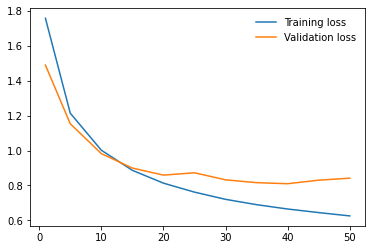

In [15]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

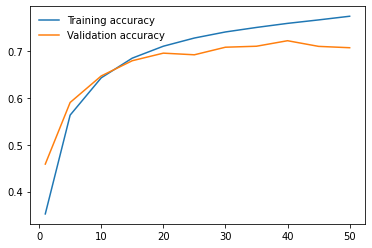

In [16]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [17]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test.to("cuda"))
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test.to("cpu"), top_class_test.to("cpu"))
print(acc_test/iter_3)

0.7084
